packages

In [1]:
import pandas as pd
import numpy as np
import re #normalize and clean
#tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

Reading data to data frame

In [2]:
df = pd.read_csv(r"Data/news.csv")

Drop id column

In [3]:
df_clean = df.drop('Unnamed: 0', axis=1)

Drop null values and empty strings

In [4]:
df_clean = df_clean.dropna()
df = df[(df['title'].str.strip() != '') & (df['text'].str.strip() != '')]
print(df_clean)

                                                  title  \
0                          You Can Smell Hillary’s Fear   
1     Watch The Exact Moment Paul Ryan Committed Pol...   
2           Kerry to go to Paris in gesture of sympathy   
3     Bernie supporters on Twitter erupt in anger ag...   
4      The Battle of New York: Why This Primary Matters   
...                                                 ...   
6330  State Department says it can't find emails fro...   
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332  Anti-Trump Protesters Are Tools of the Oligarc...   
6333  In Ethiopia, Obama seeks progress on peace, se...   
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                   text label  
0     Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1     Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2     U.S. Secretary of State John F. Kerry said Mon...  REAL  
3     — Kaydee King (@KaydeeKing) N

Check label distribution

In [5]:
count = df['label'].value_counts()
percent = df['label'].value_counts(normalize=True) * 100
summary = pd.DataFrame({'Count': count, 'Percentage': percent.round(2)})
print(summary)

       Count  Percentage
label                   
REAL    3171       50.34
FAKE    3128       49.66


Calculate and compare the average, minimum, and maximum word counts for both fake and real news

In [6]:
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))
summary = df.groupby('label')[['title_word_count', 'text_word_count']].agg(['mean', 'min', 'max']).round(2)
print(summary)

      title_word_count         text_word_count           
                  mean min max            mean min    max
label                                                    
FAKE             11.14   1  53          686.95   1  20891
REAL              9.86   2  27          873.26   7   7602


Leaning text

In [7]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mouad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Leaning data and tokenizing

In [8]:
stemmer = PorterStemmer()
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)     # keep only letters
    text = text.lower()
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)
df['clean_text'] = df['text'].apply(clean_text)

Extracting features

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text']).toarray()
y = df['label']

Split the data

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Train a Logistic Regression model

In [11]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


Evaluate model performance

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
y_pred = model.predict(X_test)


le = LabelEncoder()
y_test_enc = le.fit_transform(y_test)
y_pred_enc = le.transform(y_pred)

# Define 5-Fold cross-validation
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test_enc, y_pred_enc))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Cross-validation accuracies for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Accuracy: 0.9246031746031746
Mean Absolute Error (MAE): 0.07539682539682539

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.91      0.94      0.93       626
        REAL       0.94      0.91      0.92       634

    accuracy                           0.92      1260
   macro avg       0.92      0.92      0.92      1260
weighted avg       0.92      0.92      0.92      1260

Cross-validation accuracies for each fold: [0.92380952 0.91587302 0.90873016 0.91904762 0.91262907]
Mean CV Accuracy: 0.9160178776302684


Visualize and interpret results<br>
Confusion Matrix

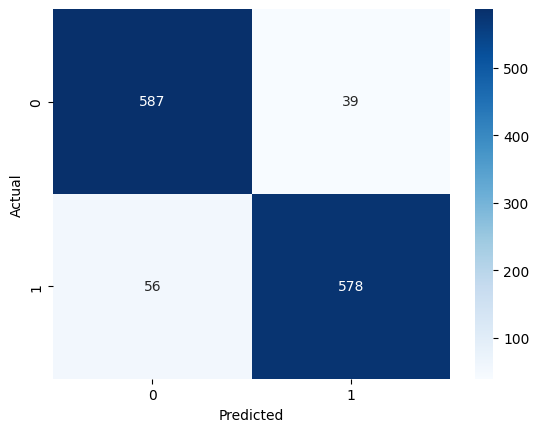

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC Curve

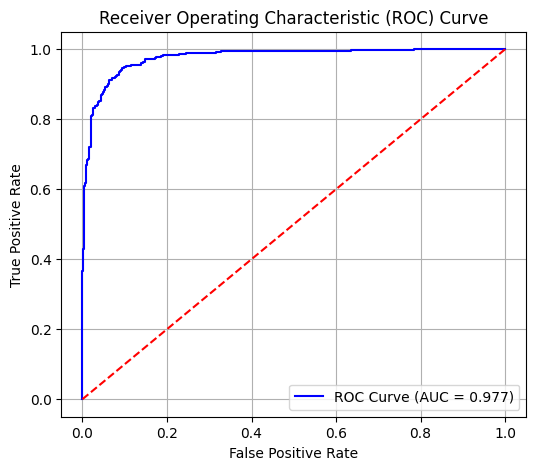

In [14]:
y_prob = model.predict_proba(X_test)[:, 1]  # probabilities for ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='REAL')
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.show()

Save model and vectorizer

In [15]:
import joblib

joblib.dump(model, 'model/fake_news_model.pkl')
joblib.dump(tfidf, 'model/tfidf_vectorizer.pkl')

['model/tfidf_vectorizer.pkl']